In [16]:
import random
import time
import datetime
import sys

import numpy as np

import glob
import random
import os

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from PIL import Image
import argparse
import itertools

import matplotlib.pyplot as plt

In [17]:
#check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

#what even: track training
class Logger():
    def __init__(self, n_epochs, batches_epoch):
        #self.viz = Visdom()
        self.n_epochs = n_epochs
        self.batches_epoch = batches_epoch
        self.epoch = 1
        self.batch = 1
        self.prev_time = time.time()
        self.mean_period = 0
        self.losses = {}
        self.loss_windows = {}
        self.image_windows = {}


    def log(self, losses=None, images=None):
        self.mean_period += (time.time() - self.prev_time)
        self.prev_time = time.time()

        sys.stdout.write('\rEpoch %03d/%03d [%04d/%04d] -- ' % (self.epoch, self.n_epochs, self.batch, self.batches_epoch))

        for i, loss_name in enumerate(losses.keys()):
            if loss_name not in self.losses:
                self.losses[loss_name] = losses[loss_name].item()   #data[0]
            else:
                self.losses[loss_name] += losses[loss_name].item()    #data[0]

            if (i+1) == len(losses.keys()):
                sys.stdout.write('%s: %.4f -- ' % (loss_name, self.losses[loss_name]/self.batch))
            else:
                sys.stdout.write('%s: %.4f | ' % (loss_name, self.losses[loss_name]/self.batch))

        batches_done = self.batches_epoch*(self.epoch - 1) + self.batch
        batches_left = self.batches_epoch*(self.n_epochs - self.epoch) + self.batches_epoch - self.batch 
        sys.stdout.write('ETA: %s' % (datetime.timedelta(seconds=batches_left*self.mean_period/batches_done)))
        
        # End of epoch
        if (self.batch % self.batches_epoch) == 0:
            
            # Plot losses
            for loss_name, loss in self.losses.items():
                #if loss_name not in self.loss_windows:
                 #   self.loss_windows[loss_name] = self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), 
                 #                                                   opts={'xlabel': 'epochs', 'ylabel': loss_name, 'title': loss_name})
                #else:
                    #self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), win=self.loss_windows[loss_name], update='append')
                # Reset losses for next epoch
                self.losses[loss_name] = 0.0 # ?
            
            
            self.epoch += 1
            self.batch = 1
            sys.stdout.write('\n')
        else:
            self.batch += 1

        
#discriminator is trained on buffer images rather than immediate output of generator
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), "black hole"
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

#lr update
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "decay should start earlier"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)


In [19]:
#datasets


class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*')) #datasets titled A and B
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

.
├── datasets                   
|   ├── <dataset_name>         #vangogh2photo
|   |   ├── train              #training
|   |   |   ├── A              #domain A images (gogh)
|   |   |   └── B              #domain B images (photos)
|   |   └── test               #testing
|   |   |   ├── A              #domain A images (gogh)
|   |   |   └── B              #domain B images (photos)

In [5]:
from matplotlib import pyplot as plt

def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [35]:
#sample images

size = 256 #crop size
dataroot = './vangogh2photo/'
transforms_ = [ transforms.Resize(int(size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]


train_test = ImageDataset(dataroot, transforms_=transforms_, unaligned=True)
x = train_test.__getitem__(index = 10)

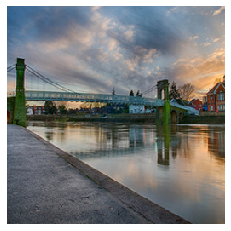

In [7]:
#myimshow(x["A"]) #gogh
myimshow(x["B"]) #photos

In [20]:
#models

import torch.nn as nn
import torch.nn.functional as F

#used within the generator
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        #initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        #downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        #residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        #upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        #output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        #series of conv layers
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        #classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        #average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [21]:
#initialize training

epoch = 0
n_epochs = 50
batchSize = 1
dataroot = './vangogh2photo/'
lr = 0.0002 
decay_epoch = 1#decay in lr starts after this epoch
size = 256 #crop size
input_nc = 3 #number of input channels
output_nc = 3 #number of output channels
n_cpu = 8 #number of cpu threads to use during batch generation
last_epoch = 0 #checkpoint usage

In [22]:
#training

#models
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

#losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

#optimizers & lr schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=4 * lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=4 * lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

#input & target memory allocation
Tensor = torch.cuda.FloatTensor if device == 'cuda' else torch.Tensor
input_A = Tensor(batchSize, input_nc, size, size)
input_B = Tensor(batchSize, output_nc, size, size)
target_real = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

#dataset loader
transforms_ = [ transforms.Resize(int(size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]

dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=batchSize, shuffle=True, num_workers=n_cpu)

#loss track and #plot
logger = Logger(n_epochs, len(dataloader))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [23]:
#reloading checkpoint before training
netG_A2B.load_state_dict(torch.load('./netG_A2B/checkpoint.pth.tar')['state_dict'])
netG_B2A.load_state_dict(torch.load('./netG_B2A/checkpoint.pth.tar')['state_dict'])
netD_A.load_state_dict(torch.load('./netD_A/checkpoint.pth.tar')['state_dict'])
netD_B.load_state_dict(torch.load('./netD_B/checkpoint.pth.tar')['state_dict'])
   
optimizer_G.load_state_dict(torch.load('./netG_A2B/checkpoint.pth.tar')['optimizer'])
optimizer_D_A.load_state_dict(torch.load('./netD_A/checkpoint.pth.tar')['optimizer'])
optimizer_D_B.load_state_dict(torch.load('./netD_B/checkpoint.pth.tar')['optimizer'])
epoch = torch.load('./netD_A/checkpoint.pth.tar')['epoch']

In [24]:
#training
print(epoch)
loss_track_g = []
loss_track_gidentity = []
loss_track_gcycle = []
loss_track_gan = []
loss_track_d = []
for epoch in range(epoch, n_epochs):
    #print(epoch)
    
    for i, batch in enumerate(dataloader):
        #set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))
        
        ##################################
        #generators A2B and B2A
        optimizer_G.zero_grad()

        #identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0 
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        #GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        #cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        #total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ####################################

        #discriminator A: between real and fake (generated) A
        optimizer_D_A.zero_grad()

        #real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        #fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        #total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        #print(loss_D_A)
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        #discriminator B
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        #print(loss_D_B)
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        #logger report
        logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                    'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
                    images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})
        loss_track_g.append(loss_G)
        loss_track_gidentity.append(loss_identity_A + loss_identity_B)
        loss_track_gcycle.append(loss_cycle_ABA + loss_cycle_BAB)
        loss_track_gan.append(loss_GAN_A2B + loss_GAN_B2A)
        loss_track_d.append(loss_D_A + loss_D_B)

    #update lr
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    #save model checkpoints
    os.makedirs('./netG_A2B', exist_ok=True)
    checkpoint_pathGAB = os.path.join('./netG_A2B', "checkpoint.pth.tar")
    torch.save({'epoch': epoch + 1, 'state_dict': netG_A2B.state_dict(), 'optimizer': optimizer_G.state_dict()}, checkpoint_pathGAB)
    os.makedirs('./netG_B2A', exist_ok=True)
    checkpoint_pathGBA = os.path.join('./netG_B2A', "checkpoint.pth.tar")
    torch.save({'epoch': epoch + 1, 'state_dict': netG_B2A.state_dict(), 'optimizer': optimizer_G.state_dict()}, checkpoint_pathGBA)
    os.makedirs('./netD_A', exist_ok=True)
    checkpoint_pathDA = os.path.join('./netD_A', "checkpoint.pth.tar")
    torch.save({'epoch': epoch + 1, 'state_dict': netD_A.state_dict(), 'optimizer': optimizer_D_A.state_dict()}, checkpoint_pathDA)
    os.makedirs('./netD_B', exist_ok=True)
    checkpoint_pathDB = os.path.join('./netD_B', "checkpoint.pth.tar")
    torch.save({'epoch': epoch + 1, 'state_dict': netD_B.state_dict(), 'optimizer': optimizer_D_B.state_dict()}, checkpoint_pathDB)

14
Epoch 001/050 [0510/0510] -- loss_G: 5.9306 | loss_G_identity: 1.5448 | loss_G_GAN: 0.9971 | loss_G_cycle: 3.3888 | loss_D: 0.5631 -- ETA: 2:25:30.54463579115002
Epoch 002/050 [0510/0510] -- loss_G: 5.8899 | loss_G_identity: 1.5432 | loss_G_GAN: 0.9973 | loss_G_cycle: 3.3494 | loss_D: 0.5676 -- ETA: 2:21:33.456408
Epoch 003/050 [0510/0510] -- loss_G: 6.0102 | loss_G_identity: 1.5630 | loss_G_GAN: 1.0382 | loss_G_cycle: 3.4090 | loss_D: 0.5447 -- ETA: 2:18:13.257782
Epoch 004/050 [0510/0510] -- loss_G: 5.9752 | loss_G_identity: 1.5449 | loss_G_GAN: 1.0285 | loss_G_cycle: 3.4018 | loss_D: 0.5388 -- ETA: 2:15:07.523552
Epoch 005/050 [0510/0510] -- loss_G: 5.6709 | loss_G_identity: 1.4771 | loss_G_GAN: 1.0042 | loss_G_cycle: 3.1896 | loss_D: 0.5254 -- ETA: 2:12:09.878840
Epoch 006/050 [0510/0510] -- loss_G: 5.7163 | loss_G_identity: 1.4805 | loss_G_GAN: 1.0118 | loss_G_cycle: 3.2240 | loss_D: 0.5044 -- ETA: 2:09:24.360315
Epoch 007/050 [0510/0510] -- loss_G: 5.6460 | loss_G_identity: 1.

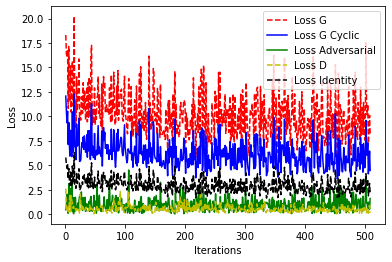

In [18]:
loss_track_g_ar = []
loss_track_gidentity_ar = []
loss_track_gcycle_ar = []
loss_track_gan_ar = []
loss_track_d_ar = []

for iter in range(1, 510*1):
    loss_track_g_ar.append(loss_track_g[iter].item())
    loss_track_gidentity_ar.append(loss_track_gidentity[iter].item())
    loss_track_gcycle_ar.append(loss_track_gcycle[iter].item())
    loss_track_gan_ar.append(loss_track_gan[iter].item())
    loss_track_d_ar.append(loss_track_d[iter].item())

iter_count = range(1, 510*1)
plt.plot(iter_count, loss_track_g_ar, 'r--')
plt.plot(iter_count, loss_track_gcycle_ar, 'b-')
plt.plot(iter_count, loss_track_gan_ar, 'g-')
plt.plot(iter_count, loss_track_d_ar, 'y--')
plt.plot(iter_count, loss_track_gidentity_ar, 'k--')

plt.legend(['Loss G', 'Loss G Cyclic', 'Loss Adversarial', 'Loss D', 'Loss Identity'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show();



In [14]:
#testing initialize

import argparse
import sys
import os

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch


#if torch.cuda.is_available() and not opt.cuda:
#    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

batchSize = 1
dataroot = './vangogh2photo'
input_nc = 3
output_nc = 3
size = 256
n_cpu = 8
generator_A2B = './netG_A2B/checkpoint.pth.tar'
generator_B2A = './netG_B2A/checkpoint.pth.tar'

#defining variables
#models
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)


netG_A2B.to(device)
netG_B2A.to(device)

#load state dicts - checkpoint models
netG_A2B.load_state_dict(torch.load('./netG_A2B/checkpoint.pth.tar')['state_dict'])
netG_B2A.load_state_dict(torch.load('./netG_B2A/checkpoint.pth.tar')['state_dict'])

#test mode
netG_A2B.eval()
netG_B2A.eval()

#input & target memory allocation
Tensor = torch.cuda.FloatTensor if device == 'cuda' else torch.Tensor
input_A = Tensor(batchSize, input_nc, size, size)
input_B = Tensor(batchSize, output_nc, size, size)

#dataset loader
transforms_ = [ transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, mode='test'), 
                        batch_size=batchSize, shuffle=False, num_workers=n_cpu)
###################################

#testing

#create output dirs if they don't exist
if not os.path.exists('./outputA'):
    os.makedirs('./outputA')
if not os.path.exists('./outputB'):
    os.makedirs('./outputB')

test_image = []

for i, batch in enumerate(dataloader):
    #set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    #generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)
    
    #test_image[i] = fake_A
    #print(fake_A)
    
    # Save image files
    save_image(fake_A, './outputA/%04d.png' % (i+1))
    save_image(fake_B, './outputB/%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

sys.stdout.write('\n')
###################################


Generated images 0751 of 0751
